In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [2]:
path = '/Users/lauritsfauli/PycharmProjects/Final_project_APML/era5'
input_files_msl = [f for f in os.listdir(path) if f.endswith('.nc') and 'mean_sea_level_pressure' in f]
input_files_msl

['era5_1943_mean_sea_level_pressure.nc',
 'era5_1944_mean_sea_level_pressure.nc',
 'era5_1942_mean_sea_level_pressure.nc',
 'era5_1940_mean_sea_level_pressure.nc',
 'era5_1941_mean_sea_level_pressure.nc']

In [3]:
input_files_msl.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
input_files_msl

['era5_1940_mean_sea_level_pressure.nc',
 'era5_1941_mean_sea_level_pressure.nc',
 'era5_1942_mean_sea_level_pressure.nc',
 'era5_1943_mean_sea_level_pressure.nc',
 'era5_1944_mean_sea_level_pressure.nc']

In [4]:
##merge the files from the list
file_paths_msl = [os.path.join(path, fname) for fname in input_files_msl]

# Then open all files with xarray
ds_msl = xr.open_mfdataset(file_paths_msl, combine='by_coords').sel(latitude=slice(70, 40.25), longitude=slice(-80, 21.75))

doy = ds_msl['valid_time'].dt.dayofyear
ds_msl = ds_msl.assign_coords(day_of_year=doy) ## 28 feb is 366. i have 2 of these in the 5 years.


def standard_scale_day(group, eps = 1e-6):
    mean_val = group.mean(dim='valid_time')
    std_val = group.std(dim='valid_time') + eps
    return (group - mean_val) / std_val

msl_stand = ds_msl['msl'].groupby('day_of_year').map(standard_scale_day)
ds_msl['msl_stand'] = msl_stand
ds_msl


<xarray.Dataset> Size: 716MB
Dimensions:      (valid_time: 1827, latitude: 120, longitude: 408)
Coordinates:
    number       int64 8B 0
  * latitude     (latitude) float64 960B 70.0 69.75 69.5 ... 40.75 40.5 40.25
  * longitude    (longitude) float64 3kB -80.0 -79.75 -79.5 ... 21.25 21.5 21.75
  * valid_time   (valid_time) datetime64[ns] 15kB 1940-01-01 ... 1944-12-31
    day_of_year  (valid_time) int64 15kB 1 2 3 4 5 6 ... 361 362 363 364 365 366
Data variables:
    msl          (valid_time, latitude, longitude) float32 358MB dask.array<chunksize=(92, 42, 320), meta=np.ndarray>
    msl_stand    (valid_time, latitude, longitude) float32 358MB dask.array<chunksize=(4, 42, 320), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-16T09:04 GRIB to CDM+CF via cfgrib-0.9.1...

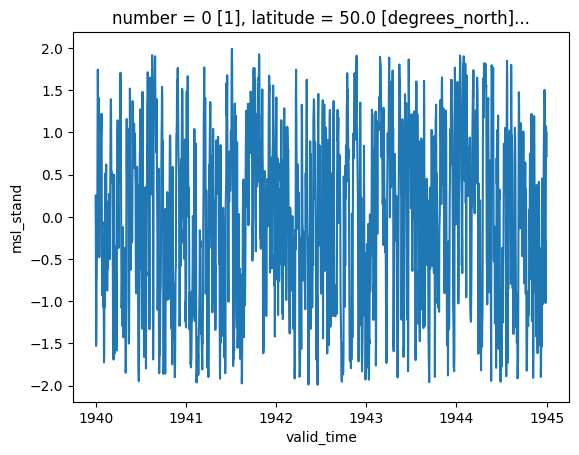

In [5]:
ds_msl.msl_stand.sel(longitude=0, latitude=50, method = 'nearest').plot()

In [6]:
msl_input = ds_msl.msl_stand.values

## cehck for nan
print(np.isnan(msl_input).any())

msl_input.shape

False


(1827, 120, 408)

['era5_1940_temperature_850hPa.nc', 'era5_1941_temperature_850hPa.nc', 'era5_1942_temperature_850hPa.nc', 'era5_1943_temperature_850hPa.nc', 'era5_1944_temperature_850hPa.nc']


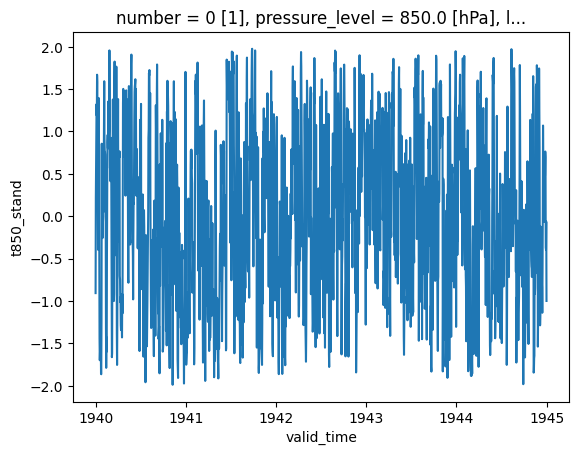

In [7]:
input_files_t850 = [f for f in os.listdir(path) if f.endswith('.nc') and '850' in f]
input_files_t850.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
print(input_files_t850)

file_paths_t850 = [os.path.join(path, fname) for fname in input_files_t850]
ds_t850 = xr.open_mfdataset(file_paths_t850, combine='by_coords').isel(pressure_level=0).sel(latitude=slice(70, 40.25), longitude=slice(-80, 21.75))

doy_t850 = ds_t850['valid_time'].dt.dayofyear
ds_t850 = ds_t850.assign_coords(day_of_year=doy_t850)
t850_stand = ds_t850['t'].groupby('day_of_year').map(standard_scale_day)
ds_t850['t850_stand'] = t850_stand
ds_t850.t850_stand.sel(longitude=0, latitude=50, method = 'nearest').plot()


In [8]:
t850_input = ds_t850.t850_stand.values

## check for nan in the data
print(np.isnan(t850_input).any())
t850_input.shape


False


(1827, 120, 408)

In [9]:
target_prec = [f for f in os.listdir(path) if f.endswith('.nc') and 'total' in f]
target_prec.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
target_prec



['era5_1940_total_precipitation.nc',
 'era5_1941_total_precipitation.nc',
 'era5_1942_total_precipitation.nc',
 'era5_1943_total_precipitation.nc',
 'era5_1944_total_precipitation.nc']

(1827,)

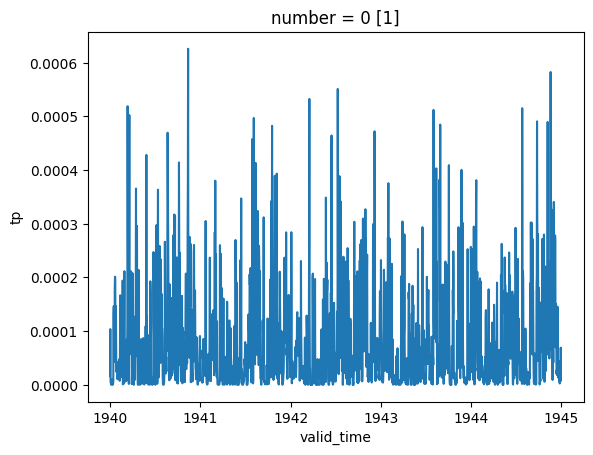

In [10]:
file_paths_prec = [os.path.join(path, fname) for fname in target_prec]
ds_prec = xr.open_mfdataset(file_paths_prec, combine='by_coords')
ds_prec = ds_prec.mean(dim= ['longitude', 'latitude'])
prec_target = ds_prec.tp.values
ds_prec.tp.plot()
prec_target.shape

In [ ]:
import sys 

import torch
import torch.optim as optim
import torch.nn as nn
from torchinfo import summary
from torcheval.metrics.functional import binary_f1_score
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# import preprocessing as prep
# import postprocessing as post
# import training as train
# import models as mod
from sklearn.metrics import roc_curve, auc, recall_score, precision_score
import pickle
from torch.utils.data import TensorDataset, DataLoader



In [ ]:
X = np.stack([t850_input, msl_input], axis=1)
X.shape
def sample_data(X, n):
    t, v, x, y = X.shape
    X_flat = X.reshape(t, v, x * y)

    # Sample every n-th element along the last dimension
    sampled_X = X_flat[:, :, ::n]

    # Split the sampled data into n parts along the last dimension
    split_X = np.array_split(sampled_X, n, axis=2)
    

    # Reshaping into (t, v, x, y) format    new_x, new_y = x // n, y // n
    new_x = x // n
    new_y = y // n

    result_datasets = []
    for i, part in enumerate(split_X):
        reshaped = part.reshape(t, v, new_x, new_y)
        # Create an xarray Dataset or DataArray from this
        da = xr.DataArray(reshaped, dims=('time', 'variable', 'x', 'y'))
        result_datasets.append(da)

    # Concatenate the datasets along time dimension
    result_datasets = xr.concat(result_datasets, dim='time')
    return result_datasets

concat_x = sample_data(X, 4).values
print(concat_x.shape)




In [ ]:
## copy prec_target 4 times and concatenate along the time dimension
prec_target_concat = np.repeat(prec_target, 4, axis=0)
prec_target_concat.shape # Add a new dimension for 'x'

In [ ]:
##import standard scaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
print(concat_x.shape)
##take 250 random samples from concat_x to test the model
test_size = 1000
random_indices = np.random.choice(concat_x.shape[0], size=test_size, replace=False)
# Create a boolean mask for test data
mask = np.zeros(concat_x.shape[0], dtype=bool)
mask[random_indices] = True

# Split the data using the mask
concat_x_test = concat_x[mask]
concat_x_train = concat_x[~mask]
scaler = MinMaxScaler()

y_test = scaler.fit_transform(prec_target_concat[mask].reshape(-1, 1))
y_train =scaler.transform(prec_target_concat[~mask].reshape(-1, 1))

# Check the shapes
print(concat_x_train.shape)
print(y_train.shape)
print(concat_x_test.shape)
print(y_test.shape)


input_shape = concat_x_train.shape[2:]
print(input_shape)

In [ ]:
X_tensor = torch.from_numpy(concat_x_train)
y_tensor = torch.from_numpy(y_train)
print(X_tensor.shape)
print(y_tensor.shape)
X = X_tensor.view(7308-test_size, -1)
y = y_tensor.view(7308-test_size, 1)

# Create dataset
dataset = TensorDataset(X, y)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FFNN(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.1):
        super().__init__()

        hidden_dims = [2048, 1024, 512, 256]

        layers = []
        prev_dim = input_dim
        for hdim in hidden_dims:
            #Saving the layer as a variable name (used for weight initialization)
            linear_layer = nn.Linear(prev_dim, hdim)
            # Initialize weights using Xavier normal
            nn.init.xavier_normal_(linear_layer.weight)
            nn.init.zeros_(linear_layer.bias)
            
            layers.append(linear_layer)
            layers.append(nn.BatchNorm1d(hdim)) 
            layers.append(nn.ELU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hdim

        # Final output layer with Xavier initialization
        final_layer = nn.Linear(prev_dim, 1)

        #weight initialization
        nn.init.xavier_normal_(final_layer.weight)
        nn.init.zeros_(final_layer.bias)

        layers.append(final_layer)
        layers.append(nn.Sigmoid()) #Sigmoid activation function

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Model setup
input_dim = input_shape[0] * input_shape[1] *2

model = FFNN(input_dim)

In [ ]:
# Print model summary
summary(model, input_size=(1, input_dim), device='cpu')

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader, random_split


# Data split (already good)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Loss, optimizer, and scheduler
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Early stopping parameters
early_stopping_patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)
    train_loss /= train_size

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:            
            pred = model(x_batch)
            loss = criterion(pred, y_batch)
            val_loss += loss.item() * x_batch.size(0)
    val_loss /= val_size

    print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {train_loss:.4f} — Val Loss: {val_loss:.4f}")

    # Step the scheduler
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss - 1e-4:  # small threshold for improvement
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # optional: save best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print("Early stopping triggered.")
            break


In [ ]:
plt.plot(y_test, label='True')

y_pred = model(torch.from_numpy(concat_x_test).view(test_size, -1)).detach().numpy()
mse = np.mean((y_pred - y_test) ** 2)
print(f'Mean Squared Error: {mse:.4f}')
plt.plot(y_pred, label='Predicted')
plt.legend()